# RENT-IT App Data Analysis Demo
For 95-880 @ Heinz College, CMU <br>
Group 12
 - Part 1 - Load web scrapping data and merge files
 - Part 2 - Data cleaning and preprocessing
 - Part 3 - Exploratory data analysis
     - Part 3.1 - Data visualization
     - Part 3.2 - Time series analysis

### Part 1: Load data and merge files

In [33]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import re
from numpy import NaN
import glob

In [34]:
l = [pd.read_csv(filename, sep=",", encoding = "ISO-8859-1") for filename in glob.glob("rent_data/*.csv")]
rent_df = pd.concat(l, ignore_index=True)

In [35]:
rent_df.head()

,Unnamed: 0,Available Date,Headline,Housing,Latitude,Longitude,Price,URL
0,0,2018-02-15,"Close Commute to CMU, PITT- 2 Bedroom 2 Bath- ...",/ 2br -,40.456368,-79.922573,$1545,https://pittsburgh.craigslist.org/apa/d/close-...
1,1,2018-02-15,"Close Commute to CMU, PITT- 2 Bedroom 1 Bath- ...",/ 2br -,40.456368,-79.922573,$1345,https://pittsburgh.craigslist.org/apa/d/close-...
2,2,2018-02-15,"Close Commute to Pitt, CMU, UPMC 2 Bed 1 Bath-...",/ 2br -,40.456368,-79.922573,$1345,https://pittsburgh.craigslist.org/apa/d/close-...
3,3,2018-02-15,"Close Commute to Pitt, CMU, UPMC 2 Bed 1 Bath-...",/ 2br -,40.456368,-79.922573,$1345,https://pittsburgh.craigslist.org/apa/d/close-...
4,4,2018-02-14,"Close to UPMC, CMU, PITT Kenmawr Apartments ON...",/ 2br -,40.456368,-79.922573,$1345,https://pittsburgh.craigslist.org/apa/d/close-...


In [36]:
rent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 8 columns):
Unnamed: 0        1200 non-null int64
Available Date    1198 non-null object
Headline          1200 non-null object
Housing           742 non-null object
Latitude          1184 non-null float64
Longitude         1184 non-null float64
Price             1200 non-null object
URL               1200 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 75.1+ KB


### Part 2: Data cleaning and preprocessing 

**part 2.1: Drop duplicate records**

In [37]:
#drop any dupplicate records according to different headline
rent_df = rent_df.drop_duplicates(subset=["Headline"]).reset_index(drop=True)

**part 2.2: Transform the 'Housing' variable**

Befroe transforming the 'Housing' variable, we have 458 missing records.

In [38]:
mask = rent_df['Housing'].isnull()
len(rent_df[mask]) #length of nan number of housing before importing

348

We will first build a function to extract useful information about housing from 'Headline' column and substitude the information into 'Housing'

In [39]:
rent_df['Housing'] = rent_df['Housing'].astype(str)

pattern = re.compile('([0-9]+)\s?(bed|bedroom|brd|br|Bedroom|BR)')
pattern_bed = re.compile('(..)([0-9]+)\s*(br)')

def convert_housing(row, pattern, pattern_bed):
    headline = row['Headline']
    housing = row['Housing']
    if housing == 'nan':
        if bool(pattern.search(headline)):
            housing = pattern.search(headline).group(1)
            housing = int(housing)
            return housing
        else:
            return('NaN')
    else:
        housing = pattern_bed.search(housing).group(2)
        housing = int(housing)
        return housing
    
rent_df['Housing'] = rent_df.apply(convert_housing, axis=1, pattern=pattern, pattern_bed = pattern_bed)

After the frist part transforming, we recovered 154 missing records and there are 304 left

In [40]:
mask = rent_df['Housing'] == 'NaN'
len(rent_df[mask]) #length of nan number after converting

227

Use average number fill in other missing values

In [41]:
temp_housing = []
for row in rent_df['Housing']:
    if row != 'NaN':
        temp_housing.append(row)
mean_housing = round(np.mean(temp_housing))
for i,row in enumerate(rent_df['Housing']):
    if row == 'NaN':
        rent_df['Housing'][i] = mean_housing

/Users/jiaozhuhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
#transform housing data type
rent_df['Housing'] = rent_df['Housing'].astype(int)
rent_df.dtypes

Unnamed: 0          int64
Available Date     object
Headline           object
Housing             int64
Latitude          float64
Longitude         float64
Price              object
URL                object
dtype: object

**part 2.3: Transform the 'Price' variable**

In [43]:
#deal with Price variable
rent_df['Price'] = rent_df['Price'].astype(str)

pattern = re.compile('^\$\d*(\,?\d{3})*')

def convert_money(row, pattern):
    price = row['Price']
    if bool(pattern.match(price)):
        price = price.replace("$", "")
        price = price.replace(",", "")
        price = float(price)
        return price
    else:
        return(NaN)
    
rent_df['Price'] = rent_df.apply(convert_money, axis=1, pattern=pattern)

In [44]:
#transform price data type
rent_df['Price'] = rent_df['Price'].astype(float)
rent_df.dtypes

Unnamed: 0          int64
Available Date     object
Headline           object
Housing             int64
Latitude          float64
Longitude         float64
Price             float64
URL                object
dtype: object

**part 2.4: Create the 'Distance' variable based on lattitude and longitude
**

In [45]:
#cmu is on (40.443322, -79.943583)
#range: latitude--(40.429331, 40.454349)
#range: longitude--(-79.961402, -79.914453)
#only concern the apartments inside this area range
import math
def cal_distance(row):
    latitude = row['Latitude']
    longitude = row['Longitude']
    distance = math.sqrt((latitude-40.443322)**2 + (longitude-(-79.943583))**2)
    if latitude >= 40.429331 and latitude <= 40.454349 and longitude >= -79.961402 and longitude <= -79.914453:
        return distance  
    else:
        return(np.nan)
rent_df['Distance'] = rent_df.apply(cal_distance, axis=1)

In [47]:
distance_df = rent_df[['Distance', 'Price']]
distance_df = distance_df.dropna(axis=0, how='any')
#distance_df

In [16]:
def distance_level(row):
    distance = row['Distance']
    interval = (max(distance_df['Distance'])-min(distance_df['Distance']))/3
    if distance >= min(distance_df['Distance']) and distance < interval:
        level = 1
    elif distance >= interval and distance < interval*2:
        level = 2
    else:
        level = 3
    return level
distance_df['Distance'] = distance_df.apply(distance_level, axis=1)

### Part 3: Exploratory data analysis

**Part 3.1: Data visualization**

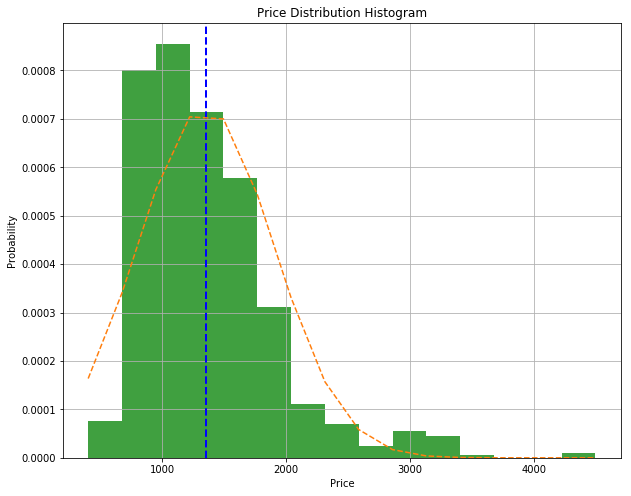

In [49]:
#general price distribution
from scipy.stats import norm
import matplotlib.mlab as mlab

x = rent_df['Price']
(mu, sigma) = norm.fit(x)
fig, ax = plt.subplots(figsize=(10,8))

n, bins, patches = plt.hist(x, 15, normed=1, facecolor='g', alpha=0.75)
ax.axvline(np.mean(x), color='b', linestyle='dashed', linewidth=2)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
ax.plot(bins, y, '--')

plt.xlabel('Price')
plt.ylabel('Probability')
plt.title('Price Distribution Histogram')
plt.grid(True)
plt.show()

As the above plot shows, the price distribution is skewed to the right. Most of the apartment near CMU has a price between 600 to 2,000. The average price is 1350.

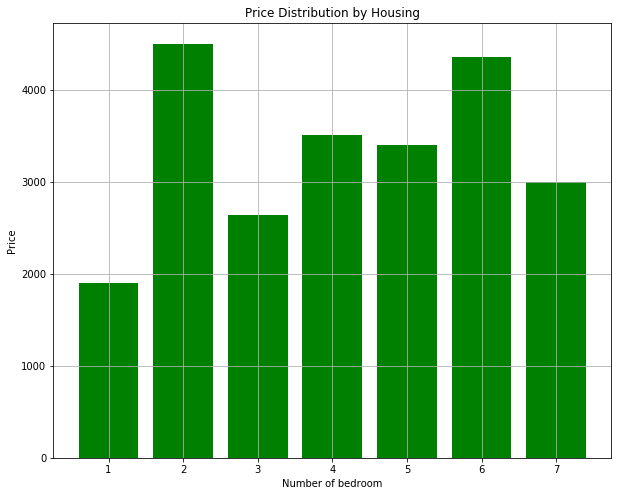

In [50]:
#price distribution by housing plan

x=rent_df['Housing']
y=rent_df['Price']

plt.figure(figsize=(10,8))
plt.bar(x,y,color='green')

plt.grid(True)
plt.xlabel('Number of bedroom')
plt.ylabel('Price')
plt.title('Price Distribution by Housing')
plt.show()

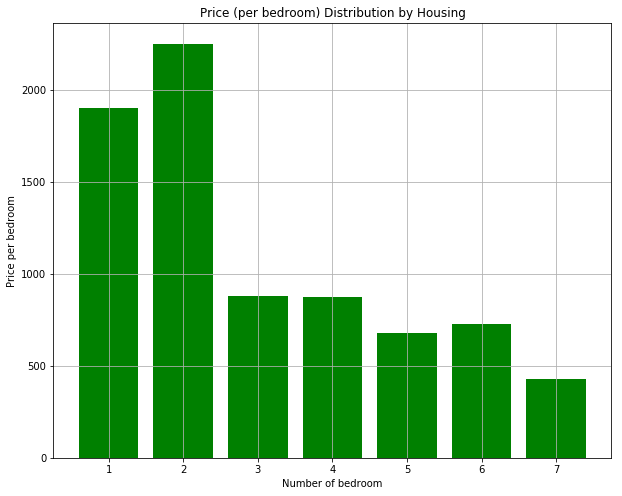

In [51]:
#price distribution by housing per bedroom
#add another variable 'Price_per_bed'
rent_df['Price_per_bed'] = rent_df['Price']/rent_df['Housing']

x = rent_df['Housing']
y = rent_df['Price_per_bed']

plt.figure(figsize=(10,8))
plt.bar(x,y,color='green')
plt.xlabel('Number of bedroom')
plt.ylabel('Price per bedroom')
plt.title('Price (per bedroom) Distribution by Housing')
plt.grid(True)
plt.show()

**Part 3.2: Time series analysis**

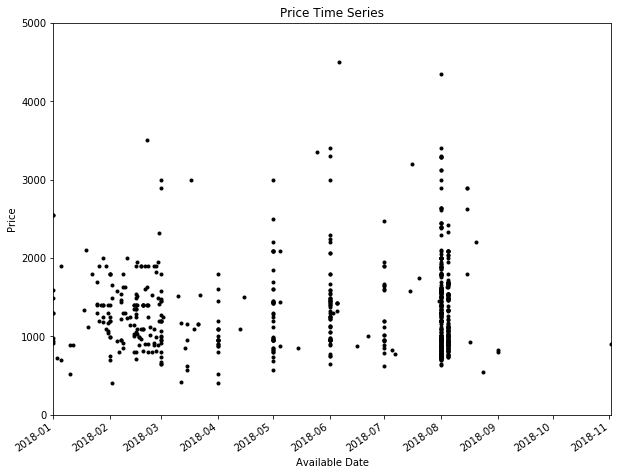

In [52]:
import matplotlib.pylab as plb

rent_df['Available Date'] = pd.to_datetime(rent_df['Available Date'])
#rent_df['Month'] = rent_df['Available Date'].dt.month

df = pd.DataFrame(columns=('Available Date', 'Price'),data=rent_df)
df = df.sort_values(by=['Available Date'])

dates = np.array(df['Available Date'])
price = np.array(df['Price'])

price_series = Series(price, index=dates)
plt.figure(figsize=(10,8))
price_series['2018-01-01':'2018-12-01'].plot(style='k.')
plt.ylim(0, 5000)
plt.xticks(rotation = 35)
plt.xlabel('Available Date')
plt.ylabel('Price')
plt.title('Price Time Series')
plt.show()

**Part 3: Regression analysis:**


In [28]:
#regress price on housing
import statsmodels.formula.api as smf
model_1 = smf.ols(formula = 'Price ~ C(Housing)', data = rent_df)
results_model1 = model_1.fit()
results_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     88.94
Date:                Sat, 03 Mar 2018   Prob (F-statistic):           2.36e-83
Time:                        18:22:06   Log-Likelihood:                -5418.6
No. Observations:                 727   AIC:                         1.085e+04
Df Residuals:                     720   BIC:                         1.088e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1004.1942     35.587     28.218      0.000     934.328    1074.061
C(Housing)[T.2]   265.5210     40.757      6.515      0.000     185.504     345.538
C(Housing)[T.3]   726.0662     55.679     13.040      0.000     616.754     835.378
C(Housing)[T.4]  1040.5558     86.910     11.973      0.000     869.928    1211.183
C(Housing)[T.5]  1453.0280    144.311     10.069      0.000    1169.707    1736.349
C(Housing)[T.6]  2385.8058    152.547     15.640      0.000    2086.315    2685.297
C(Housing)[T.7]  1995.8058    421.071      4.740      0.000    1169.133    2822.479
==============================================================================
Omnibus:                      295.147   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2023.988
Skew:                           1.672   Prob(JB):                         0.00
Kurtosis:                      10.459   Cond. No.                         32.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
rent_df['Price_per_bed'] = rent_df['Price_per_bed'].astype(int)
#rent_df.info()

In [30]:
#regress price per bedroom on housing
model_2 = smf.ols(formula = 'Price_per_bed ~ C(Housing)', data = rent_df)
results_model2 = model_2.fit()
results_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Price_per_bed   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     64.69
Date:                Sat, 03 Mar 2018   Prob (F-statistic):           3.09e-64
Time:                        18:22:09   Log-Likelihood:                -4929.1
No. Observations:                 727   AIC:                             9872.
Df Residuals:                     720   BIC:                             9904.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1004.1942     18.150     55.328      0.000     968.561    1039.827
C(Housing)[T.2]  -369.5754     20.787    -17.779      0.000    -410.385    -328.766
C(Housing)[T.3]  -427.6942     28.397    -15.061      0.000    -483.445    -371.943
C(Housing)[T.4]  -493.3371     44.326    -11.130      0.000    -580.360    -406.314
C(Housing)[T.5]  -512.7498     73.601     -6.967      0.000    -657.248    -368.251
C(Housing)[T.6]  -439.4442     77.802     -5.648      0.000    -592.189    -286.699
C(Housing)[T.7]  -576.1942    214.753     -2.683      0.007    -997.811    -154.577
==============================================================================
Omnibus:                      296.471   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1974.641
Skew:                           1.691   Prob(JB):                         0.00
Kurtosis:                      10.331   Cond. No.                         32.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
#regess price on distance
model_3 = smf.ols(formula = 'Price ~ C(Distance)', data = distance_df)
results_model3 = model_3.fit()
results_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.184
Date:                Sat, 03 Mar 2018   Prob (F-statistic):              0.307
Time:                        18:22:11   Log-Likelihood:                -3823.1
No. Observations:                 491   AIC:                             7652.
Df Residuals:                     488   BIC:                             7665.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1330.6667    150.880      8.819      0.000    1034.212    1627.121
C(Distance)[T.2]   120.9642    154.631      0.782      0.434    -182.860     424.789
C(Distance)[T.3]    42.4625    157.109      0.270      0.787    -266.231     351.156
==============================================================================
Omnibus:                      162.112   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              489.436
Skew:                           1.571   Prob(JB):                    5.25e-107
Kurtosis:                       6.749   Cond. No.                         12.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
model_3 = smf.ols(formula = 'Price ~ C(Month)', data = rent_df)
results_model3 = model_3.fit()
results_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.491
Date:                Sat, 03 Mar 2018   Prob (F-statistic):              0.138
Time:                        18:22:11   Log-Likelihood:                -5605.3
No. Observations:                 726   AIC:                         1.123e+04
Df Residuals:                     715   BIC:                         1.128e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1371.3684     89.190     15.376      0.000    1196.263    1546.474
C(Month)[T.2.0]    -57.9469    104.491     -0.555      0.579    -263.093     147.199
C(Month)[T.3.0]   -138.8684    127.873     -1.086      0.278    -389.921     112.184
C(Month)[T.4.0]   -324.5502    147.292     -2.203      0.028    -613.727     -35.373
C(Month)[T.5.0]      5.0358    119.943      0.042      0.967    -230.448     240.519
C(Month)[T.6.0]     75.5847    112.597      0.671      0.502    -145.475     296.645
C(Month)[T.7.0]      2.9173    136.933      0.021      0.983    -265.922     271.757
C(Month)[T.8.0]     -4.5528     93.488     -0.049      0.961    -188.097     178.991
C(Month)[T.9.0]   -557.3684    398.870     -1.397      0.163   -1340.464     225.727
C(Month)[T.11.0]  -471.3684    556.991     -0.846      0.398   -1564.902     622.165
C(Month)[T.12.0]   523.6316    556.991      0.940      0.347    -569.902    1617.165
==============================================================================
Omnibus:                      249.713   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              850.996
Skew:                           1.637   Prob(JB):                    1.62e-185
Kurtosis:                       7.172   Cond. No.                         32.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The above three regression models show that only 'Housing' and 'Month' are significant influencer of price, so the final model is as the the following.

In [33]:
#Final regression model for prediction
model_4 = smf.ols(formula = 'Price ~ C(Housing) + C(Month)', data = rent_df)
results_model4 = model_4.fit()
results_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     35.59
Date:                Sat, 03 Mar 2018   Prob (F-statistic):           9.10e-80
Time:                        18:22:13   Log-Likelihood:                -5398.8
No. Observations:                 726   AIC:                         1.083e+04
Df Residuals:                     709   BIC:                         1.091e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1049.8034     74.295     14.130      0.000     903.939    1195.668
C(Housing)[T.2]    260.6047     40.600      6.419      0.000     180.894     340.315
C(Housing)[T.3]    723.2321     55.338     13.069      0.000     614.586     831.878
C(Housing)[T.4]   1073.3881     88.267     12.161      0.000     900.092    1246.684
C(Housing)[T.5]   1447.0666    143.654     10.073      0.000    1165.028    1729.105
C(Housing)[T.6]   2392.0379    151.699     15.768      0.000    2094.205    2689.870
C(Housing)[T.7]   2110.4702    422.201      4.999      0.000    1281.557    2939.384
C(Month)[T.2.0]      2.4654     79.076      0.031      0.975    -152.787     157.717
C(Month)[T.3.0]   -160.2735     97.600     -1.642      0.101    -351.893      31.346
C(Month)[T.4.0]   -246.4186    111.430     -2.211      0.027    -465.190     -27.647
C(Month)[T.5.0]    -32.1188     90.893     -0.353      0.724    -210.571     146.334
C(Month)[T.6.0]      0.7376     85.430      0.009      0.993    -166.988     168.463
C(Month)[T.7.0]     62.9392    103.565      0.608      0.544    -140.391     266.269
C(Month)[T.8.0]    -51.1864     70.720     -0.724      0.469    -190.033      87.660
C(Month)[T.9.0]   -496.4081    301.692     -1.645      0.100   -1088.725      95.908
C(Month)[T.11.0] -1223.1915    427.993     -2.858      0.004   -2063.476    -382.907
C(Month)[T.12.0]   584.5919    421.077      1.388      0.165    -242.116    1411.300
==============================================================================
Omnibus:                      305.488   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2179.333
Skew:                           1.731   Prob(JB):                         0.00
Kurtosis:                      10.750   Cond. No.                         37.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""